In [1]:
##Created by: Saloni Tripathi (snt2123)


# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import morningstar
# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.classifiers.morningstar import Sector 
# Import built-in trading universe
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.pipeline.data import Fundamentals 

def make_pipeline():
    # Create a reference to our trading universe
    
    ### apply mask to filter for only tech stocks
    base_universe = Sector().eq(311) # Only select stocks in this sector.  
    base_universe &= QTradableStocksUS()  
    #base_universe &= USEquityPricing.volume.latest > 400000
    
    # Get latest closing price
    close_price = USEquityPricing.close.latest

    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Return Pipeline containing close_price and
    # sentiment_score that has our trading universe as screen
    return Pipeline(
        columns={
            'close_price': close_price,
            'sentiment_score': sentiment_score,
        },
        screen=base_universe,
    )

# Import run_pipeline method
from quantopian.research import run_pipeline

# Execute pipeline created by make_pipeline
# between start_date and end_date
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2016-06-01',
    end_date='2017-06-01'
)

# Display last 10 rows
pipeline_output.tail(100)

pipeline_output_copy = pipeline_output.copy()

pipeline_output_copy.index.name = 'date'
pipeline_output_copy.reset_index(inplace=True)
pipeline_output_copy.columns = ['date', 'stock', 'close_price', 'sentiment']

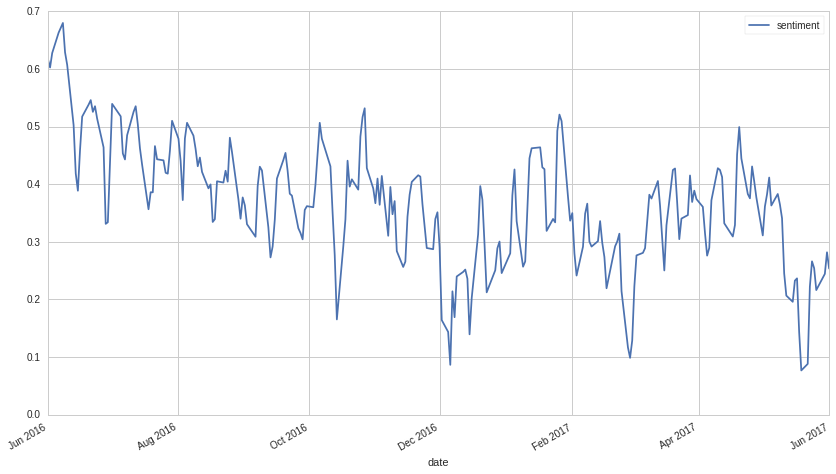

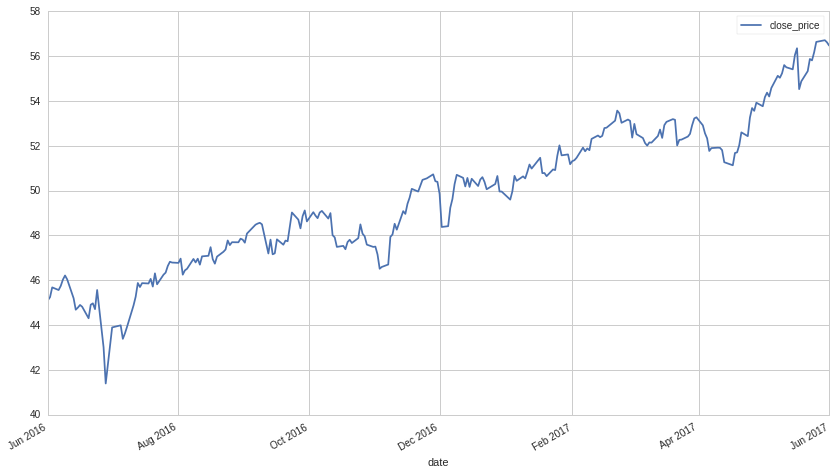

In [2]:
aggregate_sentiment = pipeline_output_copy.groupby(['date']).mean()
aggregate_sentiment.reset_index(inplace=True)
aggregate_sentiment.plot(x='date', y='sentiment')
aggregate_sentiment.plot(x='date', y='close_price')

In [17]:
IPO_STOCK_SYMBOL = 'EB'
START_DATE = '2018-12-21'
END_DATE = '2019-3-21'

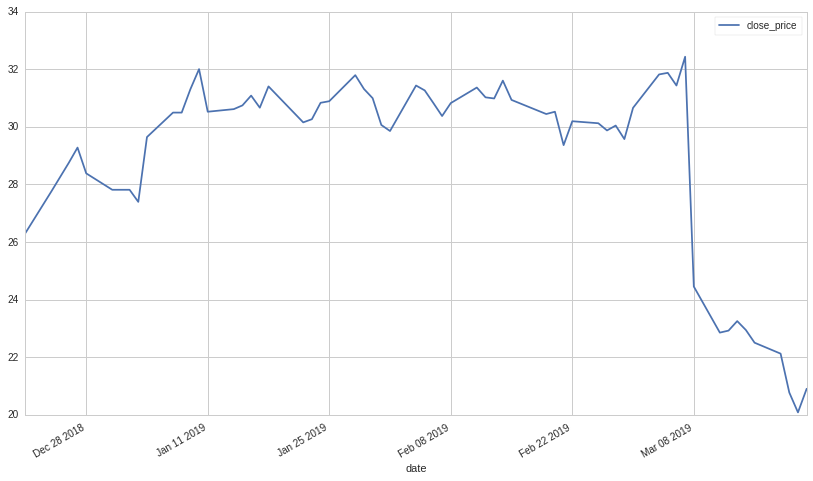

In [18]:
snap = get_pricing(IPO_STOCK_SYMBOL, start_date=START_DATE, end_date=END_DATE)
snap.index.name = 'date'
snap.reset_index(inplace=True)
snap.plot(x='date', y='close_price')

In [19]:
### GET SNAP PRICES

import quantopian.pipeline.data.morningstar as mstar
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import StaticAssets
import pandas as pd
from quantopian.research import prices
from quantopian.pipeline.data import USEquityPricing

my_symbols = [IPO_STOCK_SYMBOL]
stocks = StaticAssets(symbols(my_symbols)) 

sentiment_score = SimpleMovingAverage(
    inputs=[stocktwits.bull_minus_bear],
    window_length=3,
)

snap_pipeline = Pipeline(
    columns={
        'sentiment_score': sentiment_score,
        'close_price': USEquityPricing.close.latest,
    },
    screen=stocks,
)

pipeline_output_snap = run_pipeline(
    snap_pipeline,
    start_date=START_DATE,
    end_date=END_DATE
)

print(pipeline_output_snap)

                                              close_price  sentiment_score
2018-12-21 00:00:00+00:00 Equity(52427 [EB])       28.590         0.156111
2018-12-24 00:00:00+00:00 Equity(52427 [EB])       26.310         0.346111
2018-12-26 00:00:00+00:00 Equity(52427 [EB])       27.760         0.960000
2018-12-27 00:00:00+00:00 Equity(52427 [EB])       28.750         0.305000
2018-12-28 00:00:00+00:00 Equity(52427 [EB])       29.275         0.461667
2018-12-31 00:00:00+00:00 Equity(52427 [EB])       28.380         0.853333
2019-01-02 00:00:00+00:00 Equity(52427 [EB])       27.810         2.165000
2019-01-03 00:00:00+00:00 Equity(52427 [EB])       27.810         0.711667
2019-01-04 00:00:00+00:00 Equity(52427 [EB])       27.390         0.075000
2019-01-07 00:00:00+00:00 Equity(52427 [EB])       29.640        -1.163333
2019-01-08 00:00:00+00:00 Equity(52427 [EB])       30.490        -0.466667
2019-01-09 00:00:00+00:00 Equity(52427 [EB])       30.490        -0.158333
2019-01-10 00:00:00+00:00

In [20]:
THRESHOLD_LONG = 0.3
THRESHOLD_SHORT = 0

In [21]:
import math

price_list = pipeline_output_snap['close_price']
deltas = []
for i in range(0, len(price_list) - 3):
    three_day_delta = (price_list.get(i+3) - price_list.get(i)) / price_list.get(i)
    deltas.append(three_day_delta)

return_delta_data = {'sentiment': pipeline_output_snap['sentiment_score'][:-3], 'delta': deltas}
return_delta_data = pd.DataFrame(data=return_delta_data)

short_positions = return_delta_data['sentiment'] < THRESHOLD_SHORT
short_positions = return_delta_data[short_positions]
short_returns = -short_positions['delta'].mean()

long_positions = return_delta_data['sentiment'] > THRESHOLD_LONG
long_positions = return_delta_data[long_positions]
long_returns = -long_positions['delta'].mean()

if (math.isnan(short_returns)):
    short_returns = 0
elif (math.isnan(long_returns)):
    long_returns = 0
    
print("Long returns: " + str(long_returns))
print("Short returns: " + str(short_returns))
print("Total returns:" + str(long_returns + short_returns))

Long returns: 0.0218818531543
Short returns: 0.0050331424995
Total returns:0.0269149956538
